In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt
import csv
import numpy as np
import random
from tensorflow.python.framework import ops

In [17]:
bs = 50
lr = 0.025
it = 10000

In [3]:
def print_board(board):
    symbols = ['0', ' ', 'X']
    board_plus1 = [int(x) + 1 for x in board]
    print(' ' + symbols[board_plus1[0]] + ' | ' + symbols[board_plus1[1]] + ' | ' + symbols[board_plus1[2]])
    print('___________')
    print(' ' + symbols[board_plus1[3]] + ' | ' + symbols[board_plus1[4]] + ' | ' + symbols[board_plus1[5]])
    print('___________')
    print(' ' + symbols[board_plus1[6]] + ' | ' + symbols[board_plus1[7]] + ' | ' + symbols[board_plus1[8]])

In [4]:
def get_symmetry(board, response, transformation):
    if transformation == 'rotate180':
        new_response = 8 - response
        return (board[::-1], new_response)
    elif transformation == 'rotate90':
        new_response = [6, 3, 0, 7, 4, 1, 8, 5, 2].index(response)
        tuple_board = list(zip(*[board[6:9], board[3:6], board[0:3]]))
        return ([value for item in tuple_board for value in item], new_response)
    elif transformation == 'rotate270':
        new_response = [2, 5, 8, 1, 4, 7, 0, 3, 6].index(response)
        tuple_board = list(zip(*[board[0:3], board[3:6], board[6:9]]))[::-1]
        return ([value for item in tuple_board for value in item], new_response)
    elif transformation == 'flip_v':
        new_response = [6, 7, 8, 3, 4, 5, 0, 1, 2].index(response)
        return (board[6:9] + board[3:6] + board[0:3], new_response)
    elif transformation == 'flip_h':
        new_response = [2, 1, 0, 5, 4, 3, 8, 7, 6].index(response)
        board = board[::-1]
        return (board[6:9] + board[3:6] + board[0:3], new_response)
    else:
        raise ValueError('Method not implement.')

In [11]:
def get_moves_from_csv(csv_file):
    moves = []
    with open(csv_file, 'rt') as csvfile:
        reader = csv.reader(csvfile, delimiter=',')
        for row in reader:
            moves.append(([int(x) for x in row[0:9]], int(row[9])))
    return moves

In [12]:
def get_rand_move(moves, rand_transforms=2):
    (board, response) = random.choice(moves)
    possible_transforms = ['rotate90', 'rotate180', 'rotate270', 'flip_v', 'flip_h']
    for i in range(rand_transforms):
        random_transform = random.choice(possible_transforms)
        (board, response) = get_symmetry(board, response, random_transform)
    return (board, response)

In [28]:
def check(board):
    wins = [[0, 1, 2], [3, 4, 5], [6, 7, 8], [0, 3, 6], [1, 4, 7], [2, 5, 8], [0, 4, 8], [2, 4, 6]]
    for i in range(len(wins)):
        if board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == 1.:
            return 1
        elif board[wins[i][0]] == board[wins[i][1]] == board[wins[i][2]] == -1.:
            return 1
    return 0

In [30]:
ops.reset_default_graph()
with tf.Session() as sess:
    moves = get_moves_from_csv('base_tic_tac_toe_moves.csv')
    train_length = 500
    train_set = []
    for t in range(train_length):
        train_set.append(get_rand_move(moves))
    
    test_board = [-1, 0, 0, 1, -1, -1, 0, 0, 1]
    train_set = [x for x in train_set if x[0] != test_board]
    
    def init_weights(shape):
        return tf.Variable(tf.random_normal(shape))
    
    def model(X, A1, A2, bias1, bias2):
        layer1 = tf.nn.sigmoid(tf.add(tf.matmul(X, A1), bias1))
        layer2 = tf.add(tf.matmul(layer1, A2), bias2)
        return layer2
    
    X = tf.placeholder(dtype=tf.float32, shape=[None, 9])
    Y = tf.placeholder(dtype=tf.int32, shape=[None])
    
    A1 = init_weights([9, 81])
    bias1 = init_weights([81])
    A2 = init_weights([81, 9])
    bias2 = init_weights([9])
    model_output = model(X, A1, A2, bias1, bias2)
    
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=model_output, labels=Y))
    train_step = tf.train.GradientDescentOptimizer(lr).minimize(loss)
    prediction = tf.argmax(model_output, 1)
    
    init = tf.global_variables_initializer()
    sess.run(init)
    
    loss_vec = []
    for i in range(it):
        rand_indices = np.random.choice(len(train_set), size=bs)
        batch_data = [train_set[i] for i in rand_indices]
        x_input = [x[0] for x in batch_data]
        y_target = np.array([y[1] for y in batch_data])
        sess.run(train_step, feed_dict={X: x_input, Y: y_target})
        temp_loss = sess.run(loss, feed_dict={X: x_input, Y: y_target})
        loss_vec.append(temp_loss)

        if i % 500 == 0:
            print('iteration' + str(i) + ' Loss = ' + str(temp_loss))
            
    test_boards = [test_board]
    logits = sess.run(model_output, feed_dict={X: test_boards})
    predictions = sess.run(prediction, feed_dict={X: test_boards})
    print(predictions)
    
    game_tracker = [0., 0., 0., 0., 0., 0., 0., 0., 0.]
    win_logical = False
    num_moves = 0
    while not win_logical:
        player_index = input('Input index of your move (0-8): ')
        num_moves += 1
        game_tracker[int(player_index)] = 1
        [potential_moves] = sess.run(model_output, feed_dict={X: [game_tracker]})
        allowed_moves = [ix for ix, x in enumerate(game_tracker) if x == 0.0]
        model_move = np.argmax([x if ix in allowed_moves else -999.0
                                   for ix, x in enumerate(potential_moves)])
        game_tracker[int(model_move)] = -1.
        print('Model has moved')
        print_board(game_tracker)
        if check(game_tracker) == 1 or num_moves >= 5:
            print('Game Over!')
            win_logical = True

iteration0 Loss = 5.990233
iteration500 Loss = 1.6277739
iteration1000 Loss = 1.794357
iteration1500 Loss = 1.2636309
iteration2000 Loss = 1.2227329
iteration2500 Loss = 1.1194075
iteration3000 Loss = 1.0413337
iteration3500 Loss = 1.2077494
iteration4000 Loss = 1.0515857
iteration4500 Loss = 1.0649889
iteration5000 Loss = 0.90615463
iteration5500 Loss = 0.7275402
iteration6000 Loss = 0.81829727
iteration6500 Loss = 1.0810063
iteration7000 Loss = 0.7437689
iteration7500 Loss = 0.6470923
iteration8000 Loss = 0.6833428
iteration8500 Loss = 0.8217648
iteration9000 Loss = 1.1388118
iteration9500 Loss = 0.8669286
[6]
Model has moved
   |   |  
___________
 0 | X |  
___________
   |   |  
Model has moved
   |   |  
___________
 0 | X |  
___________
 X |   | 0
Model has moved
 0 |   | X
___________
 0 | X |  
___________
 X |   | 0
Game Over!


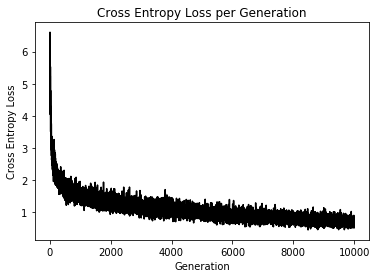

In [31]:
plt.plot(loss_vec, 'k-')
plt.title('Cross Entropy Loss per Generation')
plt.xlabel('Generation')
plt.ylabel('Cross Entropy Loss')
plt.show()